<a href="https://colab.research.google.com/github/acse-2020/acse2020-acse9-finalreport-acse-jaq15/blob/main/notebooks/CNN_GRU/CNN_GRU_Amazon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

The cells below handle all the necessary imports to run our models, making use of the public repo feeder_repo, linked <!-- [Text](link) -->
[here](https://github.com/acse-jaq15/feeder_repo).

In [1]:
# clone the feeder repo to get data_reader module and financial time series data
!git clone https://github.com/acse-jaq15/feeder_repo.git

Cloning into 'feeder_repo'...
remote: Enumerating objects: 150, done.
remote: Counting objects: 100% (150/150), done.
remote: Compressing objects: 100% (145/145), done.
remote: Total 150 (delta 73), reused 6 (delta 2), pack-reused 0
Receiving objects: 100% (150/150), 121.14 KiB | 1.66 MiB/s, done.
Resolving deltas: 100% (73/73), done.


In [2]:
# using '%' to enforce a permanent change of directory
%cd feeder_repo/

/content/feeder_repo


In [3]:
# checking contents listed correctly, should read:
# baseline_model.py data data_reader.py LICENSE README.md security_plotter.py
!ls

base_model.py  data  data_reader.py  LICENSE  README.md  security_plotter.py


In [4]:
import math
import sys
import keras
import os
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import Dropout
from keras.layers import *
from keras.utils.layer_utils import count_params
from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, Callback
from keras.optimizers import RMSprop, SGD, Adam, Nadam
from keras.initializers import random_normal

In [5]:
# appending path with 'feeder_repo' string
sys.path.append('feeder_repo')

# import Data_Reader class from data_reader module
from feeder_repo.data_reader import Data_Reader
# import Baseline_Model class from base_model module
from feeder_repo.base_model import Base_Model
# import Security_Plotter class from security_plotter module
from feeder_repo.security_plotter import Security_Plotter

In [6]:
# checking if the notebook is running on a GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

Wed Jul 21 18:51:57 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    25W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Handling the data
Here the Data_Reader class is used to read the time series data and extract training, test and validation sets, along with the relevant X and y values.

In [7]:
# storing the file to be read as a string
in_str = 'Amazon'
# storing the year of the time series to be used as test data
in_yr = 2019
# creating a variable to store the model name
model_str = 'CNN_GRU'
# setting our window_length to be 30 days
window_len = 30

In [8]:
# creating an instance of Data_Reader class
in_data = Data_Reader(in_str, in_yr)
# calling class method extract_train_test to generate training and test datasets
in_data.extract_train_test()
# calling class method extract_xy to generate X and y training and test datasets
in_data.extract_xy(window_len, time_distributed=True)

# assigning X_train and y_train
X_train = in_data.X_train
y_train = in_data.y_train

# assigning X_test and y_test
X_test = in_data.X_test
y_test = in_data.y_test

# assigning X_val_train and y_val_train
X_val_train = in_data.X_val_train
y_val_train = in_data.y_val_train

# assigning X_val_test and y_val_test
X_val_test = in_data.X_val_test
y_val_test = in_data.y_val_test

# Setting up wandb itegration
Here wandb is used to perform hyperparameter tuning.

In [9]:
# installing the wandb library and importing
%pip install wandb -q
import wandb
from wandb.keras import WandbCallback

     |████████████████████████████████| 1.8 MB 4.4 MB/s 
     |████████████████████████████████| 138 kB 55.5 MB/s 
     |████████████████████████████████| 133 kB 57.4 MB/s 
     |████████████████████████████████| 170 kB 54.0 MB/s 
     |████████████████████████████████| 97 kB 6.1 MB/s 
     |████████████████████████████████| 63 kB 1.7 MB/s 
     |████████████████████████████████| 62 kB 996 kB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.26.0 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [10]:
!pip install wandb -qq

In [11]:
# logging in so the hyperparameter tunings sweeps can be saved
!wandb login

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [12]:
# configuring the sweep, making use of a random search methodology
sweep_config = {
    'method': 'random', #grid, random
    'metric': {
      'name': 'mse',
      'goal': 'minimize'   
    },
    'parameters': {
        'epochs': {
            'values': [50, 100, 200]
        },
        'batch_size': {
            'values': [128, 64, 32]
        },
        'learning_rate': {
            'values': [0.005, 0.001, 0.0005]
        },
        'optimizer': {
            'values': ['adam', 'nadam', 'rmsprop', 'sgd']
        },
        'activation': {
            'values': ['relu', 'selu']
        }
    }
}

In [13]:
# wandb calls this training function to run through the hyperparameter search
def train():
    # default values for searching
    config_defaults = {
        'epochs': 100,
        'batch_size': 32,
        'learning_rate': 0.005,
        'optimizer': 'adam',
        'activation': 'tanh',
        'momentum': 0.9,
        'seed': 42
    }

    # Initialize a new wandb run
    wandb.init(config=config_defaults)
    
    # Config is a variable that holds and saves hyperparameters and inputs
    config = wandb.config

    # setting keras model to sequential mode
    model = Sequential()

    # layer 1
    model.add(TimeDistributed(Conv1D(filters=128, kernel_size=2, activation=config.activation), input_shape=(None, window_len, 1)))
    # layer 2
    model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
    # layer 3
    model.add(TimeDistributed(Flatten()))
    # layer 4
    model.add(GRU(units=128, activation='tanh', return_sequences=False))
    # layer 5
    model.add(Dropout(0.1))
    # layer 6
    model.add(Dense(1))

    # Define the optimizer
    if config.optimizer=='sgd':
      optimizer = SGD(learning_rate=config.learning_rate, decay=1e-5, momentum=config.momentum, nesterov=True)
    elif config.optimizer=='rmsprop':
      optimizer = RMSprop(learning_rate=config.learning_rate, decay=1e-5)
    elif config.optimizer=='adam':
      optimizer = Adam(learning_rate=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)
    elif config.optimizer=='nadam':
      optimizer = Nadam(learning_rate=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)

    model.compile(loss = "mean_squared_error", optimizer=optimizer, metrics=['mean_squared_error', 'mean_absolute_error'])

    model.fit(X_val_train, y_val_train, batch_size=config.batch_size,
              epochs=config.epochs,
              validation_data=(X_val_test, y_val_test),
              callbacks=[WandbCallback(validation_data=(X_val_test, y_val_test)),
                          EarlyStopping(patience=10, restore_best_weights=True)])

In [14]:
# setting up our sweep_id
sweep_id = wandb.sweep(sweep_config, project='ACSE_9_'+model_str)

Create sweep with ID: dvv11p34
Sweep URL: https://wandb.ai/acse-jaq15/ACSE_9_CNN_GRU/sweeps/dvv11p34


In [15]:
# initialising a new sweep
wandb.agent(sweep_id, train, project='ACSE_9_'+model_str)

wandb: Agent Starting Run: kypfeb22 with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: Currently logged in as: acse-jaq15 (use `wandb login --relogin` to force relogin)


Epoch 1/100
31/31 [==============================] - 37s 41ms/step - loss: 0.0492 - mean_squared_error: 0.0492 - mean_absolute_error: 0.1452 - val_loss: 0.0147 - val_mean_squared_error: 0.0147 - val_mean_absolute_error: 0.0857
Epoch 2/100
31/31 [==============================] - 0s 6ms/step - loss: 0.0031 - mean_squared_error: 0.0031 - mean_absolute_error: 0.0400 - val_loss: 0.0111 - val_mean_squared_error: 0.0111 - val_mean_absolute_error: 0.0802
Epoch 3/100
31/31 [==============================] - 0s 6ms/step - loss: 0.0016 - mean_squared_error: 0.0016 - mean_absolute_error: 0.0299 - val_loss: 0.0091 - val_mean_squared_error: 0.0091 - val_mean_absolute_error: 0.0742
Epoch 4/100
31/31 [==============================] - 0s 6ms/step - loss: 0.0014 - mean_squared_error: 0.0014 - mean_absolute_error: 0.0279 - val_loss: 0.0079 - val_mean_squared_error: 0.0079 - val_mean_absolute_error: 0.0670
Epoch 5/100
31/31 [==============================] - 0s 6ms/step - loss: 0.0016 - mean_squared_err

epoch,41
loss,0.00072
mean_squared_error,0.00072
mean_absolute_error,0.01936
val_loss,0.00431
val_mean_squared_error,0.00431
val_mean_absolute_error,0.04669
_runtime,53
_timestamp,1626893603
_step,41
best_val_loss,0.00401


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▁▁▂▂▂▂▁▁▁▁▁▂▂▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▄▄▃▃▂▂▄▂▂▃▂▂▂▁▂▂▄▂▁▁▁▁▁▅▁▁▁▁▁▁▁▁▂▁▁▂▁▁
val_mean_squared_error,█▆▄▄▃▃▂▂▄▂▂▃▂▂▂▁▂▂▄▂▁▁▁▁▁▅▁▁▁▁▁▁▁▁▂▁▁▂▁▁
val_mean_absolute_error,█▇▆▅▄▄▃▃▆▃▃▃▂▂▂▂▄▂▅▂▂▂▁▂▂█▂▁▁▁▁▁▁▂▂▁▁▃▁▁
_runtime,▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇█
_timestamp,▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇█
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██


wandb: Agent Starting Run: 0hpnsnhw with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/200
8/8 [==============================] - 4s 151ms/step - loss: 0.2228 - mean_squared_error: 0.2228 - mean_absolute_error: 0.2872 - val_loss: 0.0138 - val_mean_squared_error: 0.0138 - val_mean_absolute_error: 0.0961
Epoch 2/200
8/8 [==============================] - 0s 8ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - mean_absolute_error: 0.0336 - val_loss: 0.0202 - val_mean_squared_error: 0.0202 - val_mean_absolute_error: 0.1010
Epoch 3/200
8/8 [==============================] - 0s 7ms/step - loss: 0.0149 - mean_squared_error: 0.0149 - mean_absolute_error: 0.0886 - val_loss: 0.0605 - val_mean_squared_error: 0.0605 - val_mean_absolute_error: 0.2016
Epoch 4/200
8/8 [==============================] - 0s 7ms/step - loss: 0.0187 - mean_squared_error: 0.0187 - mean_absolute_error: 0.1073 - val_loss: 0.0321 - val_mean_squared_error: 0.0321 - val_mean_absolute_error: 0.1348
Epoch 5/200
8/8 [==============================] - 0s 8ms/step - loss: 0.0173 - mean_squared_error: 0.0173

epoch,46
loss,0.00228
mean_squared_error,0.00228
mean_absolute_error,0.03711
val_loss,0.01253
val_mean_squared_error,0.01253
val_mean_absolute_error,0.08071
_runtime,11
_timestamp,1626893640
_step,46
best_val_loss,0.00794


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▂▂▂▂▁▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▂▂▂▂▁▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▁▅▄▄▄▃▃▂▃▂▃▃▃▂▃▂▂▂▂▁▂▂▂▂▂▂▁▂▂▂▂▁▂▂▁▂▂▂▁
val_loss,▁▂▅▃▂▃▄▁█▁▅▂▂▂▃▂▂▂▁▂▁▂▁▁▁▁▁▁▂▁▁▁▃▁▁▂▁▁▁▁
val_mean_squared_error,▁▂▅▃▂▃▄▁█▁▅▂▂▂▃▂▂▂▁▂▁▂▁▁▁▁▁▁▂▁▁▁▃▁▁▂▁▁▁▁
val_mean_absolute_error,▂▂▅▃▂▄▅▂█▁▆▂▂▂▄▂▂▃▁▂▁▂▂▂▁▂▁▂▂▁▂▁▄▁▁▂▁▁▁▁
_runtime,▁▁▁▃▃▃▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆██████
_timestamp,▁▁▁▃▃▃▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆██████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: rptlz80u with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/200
8/8 [==============================] - 4s 113ms/step - loss: 0.0724 - mean_squared_error: 0.0724 - mean_absolute_error: 0.1922 - val_loss: 0.0554 - val_mean_squared_error: 0.0554 - val_mean_absolute_error: 0.2077
Epoch 2/200
8/8 [==============================] - 0s 10ms/step - loss: 0.0226 - mean_squared_error: 0.0226 - mean_absolute_error: 0.1135 - val_loss: 0.0455 - val_mean_squared_error: 0.0455 - val_mean_absolute_error: 0.1641
Epoch 3/200
8/8 [==============================] - 0s 7ms/step - loss: 0.0100 - mean_squared_error: 0.0100 - mean_absolute_error: 0.0768 - val_loss: 0.0201 - val_mean_squared_error: 0.0201 - val_mean_absolute_error: 0.1277
Epoch 4/200
8/8 [==============================] - 0s 8ms/step - loss: 0.0057 - mean_squared_error: 0.0057 - mean_absolute_error: 0.0556 - val_loss: 0.0209 - val_mean_squared_error: 0.0209 - val_mean_absolute_error: 0.1007
Epoch 5/200
8/8 [==============================] - 0s 8ms/step - loss: 0.0033 - mean_squared_error: 0.003

epoch,165
loss,0.00057
mean_squared_error,0.00057
mean_absolute_error,0.01683
val_loss,0.00474
val_mean_squared_error,0.00474
val_mean_absolute_error,0.05053
_runtime,24
_timestamp,1626893676
_step,165
best_val_loss,0.00473


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: ul1cpoq8 with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/50
8/8 [==============================] - 3s 113ms/step - loss: 0.1224 - mean_squared_error: 0.1224 - mean_absolute_error: 0.2452 - val_loss: 0.0723 - val_mean_squared_error: 0.0723 - val_mean_absolute_error: 0.2388
Epoch 2/50
8/8 [==============================] - 0s 7ms/step - loss: 0.0232 - mean_squared_error: 0.0232 - mean_absolute_error: 0.1128 - val_loss: 0.0198 - val_mean_squared_error: 0.0198 - val_mean_absolute_error: 0.1010
Epoch 3/50
8/8 [==============================] - 0s 7ms/step - loss: 0.0064 - mean_squared_error: 0.0064 - mean_absolute_error: 0.0579 - val_loss: 0.0171 - val_mean_squared_error: 0.0171 - val_mean_absolute_error: 0.0977
Epoch 4/50
8/8 [==============================] - 0s 7ms/step - loss: 0.0046 - mean_squared_error: 0.0046 - mean_absolute_error: 0.0503 - val_loss: 0.0160 - val_mean_squared_error: 0.0160 - val_mean_absolute_error: 0.1124
Epoch 5/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0041 - mean_squared_error: 0.0041 - me

epoch,49
loss,0.00073
mean_squared_error,0.00073
mean_absolute_error,0.01942
val_loss,0.00551
val_mean_squared_error,0.00551
val_mean_absolute_error,0.05489
_runtime,15
_timestamp,1626893703
_step,49
best_val_loss,0.00551


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇██
_timestamp,▁▁▁▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: yup01e4g with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/50
8/8 [==============================] - 4s 111ms/step - loss: 0.0632 - mean_squared_error: 0.0632 - mean_absolute_error: 0.1384 - val_loss: 0.0274 - val_mean_squared_error: 0.0274 - val_mean_absolute_error: 0.1473
Epoch 2/50
8/8 [==============================] - 0s 10ms/step - loss: 0.0199 - mean_squared_error: 0.0199 - mean_absolute_error: 0.1032 - val_loss: 0.0246 - val_mean_squared_error: 0.0246 - val_mean_absolute_error: 0.1397
Epoch 3/50
8/8 [==============================] - 0s 10ms/step - loss: 0.0077 - mean_squared_error: 0.0077 - mean_absolute_error: 0.0649 - val_loss: 0.0191 - val_mean_squared_error: 0.0191 - val_mean_absolute_error: 0.1238
Epoch 4/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0059 - mean_squared_error: 0.0059 - mean_absolute_error: 0.0562 - val_loss: 0.0129 - val_mean_squared_error: 0.0129 - val_mean_absolute_error: 0.0985
Epoch 5/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0028 - mean_squared_error: 0.0028 - 

epoch,49
loss,0.00147
mean_squared_error,0.00147
mean_absolute_error,0.02737
val_loss,0.00818
val_mean_squared_error,0.00818
val_mean_absolute_error,0.06434
_runtime,13
_timestamp,1626893729
_step,49
best_val_loss,0.00645


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▅▂▂▄▂▁▁▁▄▂▁▁▁▁▁▂▄▁▁▁▁▁▁▂▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁
mean_squared_error,█▅▂▂▄▂▁▁▁▄▂▁▁▁▁▁▂▄▁▁▁▁▁▁▂▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁
mean_absolute_error,▇█▄▄▇▅▂▂▂▆▃▂▂▂▁▁▃▇▂▁▂▁▂▁▃▂▁▁▁▄▃▁▁▁▁▁▁▂▁▁
val_loss,▇▇▅▃█▃▃▂▃▆▂▃▂▂▂▂▅▂▂▁▁▂▁▁▂▁▁▁▂▅▁▁▁▁▁▁▂▁▂▂
val_mean_squared_error,▇▇▅▃█▃▃▂▃▆▂▃▂▂▂▂▅▂▂▁▁▂▁▁▂▁▁▁▂▅▁▁▁▁▁▁▂▁▂▂
val_mean_absolute_error,█▇▆▄█▄▃▃▄▆▃▄▂▂▂▂▆▂▂▂▂▂▂▁▃▂▂▂▂▅▁▁▁▁▁▁▂▁▂▁
_runtime,▁▁▁▁▂▂▂▂▂▂▂▂▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▇▇▇▇▇▇▇██████
_timestamp,▁▁▁▁▂▂▂▂▂▂▂▂▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▇▇▇▇▇▇▇██████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: nt4e7esq with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/200
16/16 [==============================] - 4s 61ms/step - loss: 0.3168 - mean_squared_error: 0.3168 - mean_absolute_error: 0.2753 - val_loss: 0.0963 - val_mean_squared_error: 0.0963 - val_mean_absolute_error: 0.2825
Epoch 2/200
16/16 [==============================] - 0s 9ms/step - loss: 0.0145 - mean_squared_error: 0.0145 - mean_absolute_error: 0.0754 - val_loss: 0.0147 - val_mean_squared_error: 0.0147 - val_mean_absolute_error: 0.0908
Epoch 3/200
16/16 [==============================] - 0s 10ms/step - loss: 0.0025 - mean_squared_error: 0.0025 - mean_absolute_error: 0.0371 - val_loss: 0.0129 - val_mean_squared_error: 0.0129 - val_mean_absolute_error: 0.0926
Epoch 4/200
16/16 [==============================] - 0s 8ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - mean_absolute_error: 0.0349 - val_loss: 0.0231 - val_mean_squared_error: 0.0231 - val_mean_absolute_error: 0.1106
Epoch 5/200
16/16 [==============================] - 0s 10ms/step - loss: 0.0037 - mean_squared_er

epoch,51
loss,0.002
mean_squared_error,0.002
mean_absolute_error,0.03351
val_loss,0.00826
val_mean_squared_error,0.00826
val_mean_absolute_error,0.06681
_runtime,16
_timestamp,1626893762
_step,51
best_val_loss,0.00663


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▁▂▂▁▃▂▂▂▁▂▂▁▁▂▁▁▁▂▁▁▃▁▁▁▂▂▁▂▁▁▂▁▁▂
val_loss,█▂▁▂▃▁▂▁▁▁▁▁▂▁▁▁▃▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▂▁▂▃▁▂▁▁▁▁▁▂▁▁▁▃▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▂▂▃▄▂▂▂▂▂▁▁▂▁▁▂▄▁▁▁▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁
_runtime,▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
_timestamp,▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: exanpfop with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/50
31/31 [==============================] - 3s 39ms/step - loss: 0.0454 - mean_squared_error: 0.0454 - mean_absolute_error: 0.1432 - val_loss: 0.0155 - val_mean_squared_error: 0.0155 - val_mean_absolute_error: 0.1025
Epoch 2/50
31/31 [==============================] - 0s 5ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - mean_absolute_error: 0.0317 - val_loss: 0.0142 - val_mean_squared_error: 0.0142 - val_mean_absolute_error: 0.0938
Epoch 3/50
31/31 [==============================] - 0s 6ms/step - loss: 0.0014 - mean_squared_error: 0.0014 - mean_absolute_error: 0.0267 - val_loss: 0.0131 - val_mean_squared_error: 0.0131 - val_mean_absolute_error: 0.0882
Epoch 4/50
31/31 [==============================] - 0s 6ms/step - loss: 0.0013 - mean_squared_error: 0.0013 - mean_absolute_error: 0.0252 - val_loss: 0.0116 - val_mean_squared_error: 0.0116 - val_mean_absolute_error: 0.0834
Epoch 5/50
31/31 [==============================] - 0s 7ms/step - loss: 0.0014 - mean_squared_error: 0.

epoch,49
loss,0.00061
mean_squared_error,0.00061
mean_absolute_error,0.01761
val_loss,0.00526
val_mean_squared_error,0.00526
val_mean_absolute_error,0.05169
_runtime,19
_timestamp,1626893795
_step,49
best_val_loss,0.00416


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁
val_loss,█▇▇▆▅▄▅▄▃▃▄▂▃▃▂▂▃▂▂▂▂▂▂▂▂▁▂▂▁▂▁▂▂▂▁▂▂▁▁▂
val_mean_squared_error,█▇▇▆▅▄▅▄▃▃▄▂▃▃▂▂▃▂▂▂▂▂▂▂▂▁▂▂▁▂▁▂▂▂▁▂▂▁▁▂
val_mean_absolute_error,█▇▆▆▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▂▁▁▁▂▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇█
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: tq29wyqx with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: sgd


Epoch 1/100
8/8 [==============================] - 3s 120ms/step - loss: 0.2621 - mean_squared_error: 0.2621 - mean_absolute_error: 0.4032 - val_loss: 0.2573 - val_mean_squared_error: 0.2573 - val_mean_absolute_error: 0.4734
Epoch 2/100
8/8 [==============================] - 0s 9ms/step - loss: 0.1178 - mean_squared_error: 0.1178 - mean_absolute_error: 0.2604 - val_loss: 0.0682 - val_mean_squared_error: 0.0682 - val_mean_absolute_error: 0.2276
Epoch 3/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0281 - mean_squared_error: 0.0281 - mean_absolute_error: 0.1328 - val_loss: 0.0145 - val_mean_squared_error: 0.0145 - val_mean_absolute_error: 0.0992
Epoch 4/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0109 - mean_squared_error: 0.0109 - mean_absolute_error: 0.0883 - val_loss: 0.0131 - val_mean_squared_error: 0.0131 - val_mean_absolute_error: 0.0818
Epoch 5/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0112 - mean_squared_error: 0.0112

epoch,23
loss,0.00218
mean_squared_error,0.00218
mean_absolute_error,0.03478
val_loss,0.0116
val_mean_squared_error,0.0116
val_mean_absolute_error,0.08602
_runtime,10
_timestamp,1626893818
_step,23
best_val_loss,0.01136


epoch,▁▁▂▂▂▃▃▃▃▄▄▄▅▅▅▆▆▆▆▇▇▇██
loss,█▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▁▁▁▅▅▅▅▅▅▅▅▅▅▅██████
_timestamp,▁▁▁▁▁▁▁▅▅▅▅▅▅▅▅▅▅▅██████
_step,▁▁▂▂▂▃▃▃▃▄▄▄▅▅▅▆▆▆▆▇▇▇██


wandb: Agent Starting Run: 3iako1cd with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: sgd


Epoch 1/50
16/16 [==============================] - 3s 54ms/step - loss: 0.1789 - mean_squared_error: 0.1789 - mean_absolute_error: 0.3321 - val_loss: 0.1869 - val_mean_squared_error: 0.1869 - val_mean_absolute_error: 0.3994
Epoch 2/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0912 - mean_squared_error: 0.0912 - mean_absolute_error: 0.2306 - val_loss: 0.0696 - val_mean_squared_error: 0.0696 - val_mean_absolute_error: 0.2279
Epoch 3/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0351 - mean_squared_error: 0.0351 - mean_absolute_error: 0.1544 - val_loss: 0.0275 - val_mean_squared_error: 0.0275 - val_mean_absolute_error: 0.1385
Epoch 4/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0195 - mean_squared_error: 0.0195 - mean_absolute_error: 0.1192 - val_loss: 0.0172 - val_mean_squared_error: 0.0172 - val_mean_absolute_error: 0.1080
Epoch 5/50
16/16 [==============================] - 0s 6ms/step - loss: 0.0156 - mean_squared_error: 0.

epoch,25
loss,0.00193
mean_squared_error,0.00193
mean_absolute_error,0.03382
val_loss,0.01273
val_mean_squared_error,0.01273
val_mean_absolute_error,0.08967
_runtime,11
_timestamp,1626893842
_step,25
best_val_loss,0.0122


epoch,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▁▃▃▃▃▃▃▆▆▆▆▆▆▆████████
_timestamp,▁▁▁▁▁▃▃▃▃▃▃▆▆▆▆▆▆▆████████
_step,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇██


wandb: Agent Starting Run: wh4c3w7a with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: sgd


Epoch 1/200
8/8 [==============================] - 3s 110ms/step - loss: 0.1988 - mean_squared_error: 0.1988 - mean_absolute_error: 0.3528 - val_loss: 0.1999 - val_mean_squared_error: 0.1999 - val_mean_absolute_error: 0.4161
Epoch 2/200
8/8 [==============================] - 0s 7ms/step - loss: 0.0897 - mean_squared_error: 0.0897 - mean_absolute_error: 0.2302 - val_loss: 0.0592 - val_mean_squared_error: 0.0592 - val_mean_absolute_error: 0.2121
Epoch 3/200
8/8 [==============================] - 0s 8ms/step - loss: 0.0246 - mean_squared_error: 0.0246 - mean_absolute_error: 0.1216 - val_loss: 0.0154 - val_mean_squared_error: 0.0154 - val_mean_absolute_error: 0.1069
Epoch 4/200
8/8 [==============================] - 0s 10ms/step - loss: 0.0085 - mean_squared_error: 0.0085 - mean_absolute_error: 0.0775 - val_loss: 0.0131 - val_mean_squared_error: 0.0131 - val_mean_absolute_error: 0.0847
Epoch 5/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0088 - mean_squared_error: 0.008

epoch,16
loss,0.0028
mean_squared_error,0.0028
mean_absolute_error,0.04186
val_loss,0.01279
val_mean_squared_error,0.01279
val_mean_absolute_error,0.09339
_runtime,9
_timestamp,1626893864
_step,16
best_val_loss,0.0125


epoch,▁▁▂▂▃▃▄▄▅▅▅▆▆▇▇██
loss,█▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▁▁▁██████████
_timestamp,▁▁▁▁▁▁▁██████████
_step,▁▁▂▂▃▃▄▄▅▅▅▆▆▇▇██


wandb: Agent Starting Run: yc51qm99 with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd


Epoch 1/100
8/8 [==============================] - 3s 116ms/step - loss: 0.3088 - mean_squared_error: 0.3088 - mean_absolute_error: 0.4357 - val_loss: 0.1671 - val_mean_squared_error: 0.1671 - val_mean_absolute_error: 0.3725
Epoch 2/100
8/8 [==============================] - 0s 12ms/step - loss: 0.0607 - mean_squared_error: 0.0607 - mean_absolute_error: 0.1872 - val_loss: 0.0136 - val_mean_squared_error: 0.0136 - val_mean_absolute_error: 0.0867
Epoch 3/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0185 - mean_squared_error: 0.0185 - mean_absolute_error: 0.1220 - val_loss: 0.0296 - val_mean_squared_error: 0.0296 - val_mean_absolute_error: 0.1319
Epoch 4/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0222 - mean_squared_error: 0.0222 - mean_absolute_error: 0.1404 - val_loss: 0.0163 - val_mean_squared_error: 0.0163 - val_mean_absolute_error: 0.0875
Epoch 5/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0090 - mean_squared_error: 0.00

epoch,17
loss,0.00242
mean_squared_error,0.00242
mean_absolute_error,0.0351
val_loss,0.0134
val_mean_squared_error,0.0134
val_mean_absolute_error,0.09324
_runtime,9
_timestamp,1626893886
_step,17
best_val_loss,0.01281


epoch,▁▁▂▂▃▃▃▄▄▅▅▆▆▆▇▇██
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▁▁▁▁██████████
_timestamp,▁▁▁▁▁▁▁▁██████████
_step,▁▁▂▂▃▃▃▄▄▅▅▆▆▆▇▇██


wandb: Agent Starting Run: kbyl283z with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/100
16/16 [==============================] - 4s 79ms/step - loss: 0.0647 - mean_squared_error: 0.0647 - mean_absolute_error: 0.1633 - val_loss: 0.0264 - val_mean_squared_error: 0.0264 - val_mean_absolute_error: 0.1153
Epoch 2/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0049 - mean_squared_error: 0.0049 - mean_absolute_error: 0.0515 - val_loss: 0.0149 - val_mean_squared_error: 0.0149 - val_mean_absolute_error: 0.0928
Epoch 3/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0028 - mean_squared_error: 0.0028 - mean_absolute_error: 0.0380 - val_loss: 0.0135 - val_mean_squared_error: 0.0135 - val_mean_absolute_error: 0.0946
Epoch 4/100
16/16 [==============================] - 0s 6ms/step - loss: 0.0019 - mean_squared_error: 0.0019 - mean_absolute_error: 0.0319 - val_loss: 0.0128 - val_mean_squared_error: 0.0128 - val_mean_absolute_error: 0.0951
Epoch 5/100
16/16 [==============================] - 0s 6ms/step - loss: 0.0017 - mean_squared_erro

epoch,99
loss,0.00082
mean_squared_error,0.00082
mean_absolute_error,0.02043
val_loss,0.00782
val_mean_squared_error,0.00782
val_mean_absolute_error,0.06567
_runtime,22
_timestamp,1626893922
_step,99
best_val_loss,0.00447


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▃▃▃▂▂▃▃▂▂▂▂▂▂▁▂▁▂▂▁▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▂
val_mean_squared_error,█▄▃▃▃▃▂▂▃▃▂▂▂▂▂▂▁▂▁▂▂▁▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▂
val_mean_absolute_error,█▆▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▃
_runtime,▁▁▁▁▂▂▃▃▃▃▃▃▃▃▃▄▄▅▅▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▃▃▃▃▃▃▃▃▃▄▄▅▅▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: klbctza3 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/50
31/31 [==============================] - 3s 33ms/step - loss: 1.0893 - mean_squared_error: 1.0893 - mean_absolute_error: 0.3884 - val_loss: 0.1174 - val_mean_squared_error: 0.1174 - val_mean_absolute_error: 0.3162
Epoch 2/50
31/31 [==============================] - 0s 6ms/step - loss: 0.0419 - mean_squared_error: 0.0419 - mean_absolute_error: 0.1387 - val_loss: 0.0798 - val_mean_squared_error: 0.0798 - val_mean_absolute_error: 0.2590
Epoch 3/50
31/31 [==============================] - 0s 6ms/step - loss: 0.0268 - mean_squared_error: 0.0268 - mean_absolute_error: 0.1052 - val_loss: 0.0304 - val_mean_squared_error: 0.0304 - val_mean_absolute_error: 0.1319
Epoch 4/50
31/31 [==============================] - 0s 7ms/step - loss: 0.0116 - mean_squared_error: 0.0116 - mean_absolute_error: 0.0817 - val_loss: 0.0510 - val_mean_squared_error: 0.0510 - val_mean_absolute_error: 0.2016
Epoch 5/50
31/31 [==============================] - 0s 7ms/step - loss: 0.0079 - mean_squared_error: 0.

epoch,48
loss,0.00154
mean_squared_error,0.00154
mean_absolute_error,0.02887
val_loss,0.00849
val_mean_squared_error,0.00849
val_mean_absolute_error,0.06579
_runtime,20
_timestamp,1626893961
_step,48
best_val_loss,0.00624


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▃▄▁▂▂▂▃▂▂▁▃▂▁▂▁▁▁▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▆▃▄▁▂▂▂▃▂▂▁▃▂▁▂▁▁▁▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▃▅▂▂▃▂▄▃▂▁▃▃▁▂▁▁▁▃▂▂▂▁▂▁▁▃▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇██
_timestamp,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: byo7keed with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/100
31/31 [==============================] - 4s 44ms/step - loss: 1.1800 - mean_squared_error: 1.1800 - mean_absolute_error: 0.6105 - val_loss: 0.0156 - val_mean_squared_error: 0.0156 - val_mean_absolute_error: 0.0953
Epoch 2/100
31/31 [==============================] - 0s 7ms/step - loss: 0.0042 - mean_squared_error: 0.0042 - mean_absolute_error: 0.0493 - val_loss: 0.0131 - val_mean_squared_error: 0.0131 - val_mean_absolute_error: 0.0901
Epoch 3/100
31/31 [==============================] - 0s 6ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - mean_absolute_error: 0.0333 - val_loss: 0.0122 - val_mean_squared_error: 0.0122 - val_mean_absolute_error: 0.0977
Epoch 4/100
31/31 [==============================] - 0s 7ms/step - loss: 0.0027 - mean_squared_error: 0.0027 - mean_absolute_error: 0.0392 - val_loss: 0.0096 - val_mean_squared_error: 0.0096 - val_mean_absolute_error: 0.0777
Epoch 5/100
31/31 [==============================] - 0s 7ms/step - loss: 0.0017 - mean_squared_erro

epoch,64
loss,0.00059
mean_squared_error,0.00059
mean_absolute_error,0.01788
val_loss,0.00466
val_mean_squared_error,0.00466
val_mean_absolute_error,0.05576
_runtime,26
_timestamp,1626894006
_step,64
best_val_loss,0.00356


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▅▄▃▃▂▂▃▂▄▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▂
val_mean_squared_error,█▇▅▄▃▃▂▂▃▂▄▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▂
val_mean_absolute_error,█▇▆▅▅▄▃▃▅▃▆▂▂▂▂▃▂▂▃▁▁▂▂▁▁▁▁▂▁▁▁▂▃▁▂▁▂▂▁▃
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: lqdfh07n with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/100
31/31 [==============================] - 3s 33ms/step - loss: 0.0726 - mean_squared_error: 0.0726 - mean_absolute_error: 0.1718 - val_loss: 0.0154 - val_mean_squared_error: 0.0154 - val_mean_absolute_error: 0.0874
Epoch 2/100
31/31 [==============================] - 0s 7ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - mean_absolute_error: 0.0421 - val_loss: 0.0103 - val_mean_squared_error: 0.0103 - val_mean_absolute_error: 0.0825
Epoch 3/100
31/31 [==============================] - 0s 7ms/step - loss: 0.0017 - mean_squared_error: 0.0017 - mean_absolute_error: 0.0302 - val_loss: 0.0090 - val_mean_squared_error: 0.0090 - val_mean_absolute_error: 0.0740
Epoch 4/100
31/31 [==============================] - 0s 8ms/step - loss: 0.0016 - mean_squared_error: 0.0016 - mean_absolute_error: 0.0281 - val_loss: 0.0079 - val_mean_squared_error: 0.0079 - val_mean_absolute_error: 0.0701
Epoch 5/100
31/31 [==============================] - 0s 8ms/step - loss: 0.0012 - mean_squared_erro

epoch,55
loss,0.00059
mean_squared_error,0.00059
mean_absolute_error,0.01776
val_loss,0.00395
val_mean_squared_error,0.00395
val_mean_absolute_error,0.04791
_runtime,22
_timestamp,1626894062
_step,55
best_val_loss,0.00382


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▁▁▂▁▁▁▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▄▃▄▂▄▃▃▂▂▂▂▁▂▂▂▂▂▃▂▁▃▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▅▄▃▄▂▄▃▃▂▂▂▂▁▂▂▂▂▂▃▂▁▃▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▆▅▅▃▆▅▄▃▂▂▃▂▂▃▂▃▄▃▂▁▄▂▂▁▁▁▃▂▂▂▁▂▁▂▂▁▁▁
_runtime,▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇█
_timestamp,▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇█
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 603mb13e with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/50
31/31 [==============================] - 3s 30ms/step - loss: 0.0443 - mean_squared_error: 0.0443 - mean_absolute_error: 0.1148 - val_loss: 0.0118 - val_mean_squared_error: 0.0118 - val_mean_absolute_error: 0.0886
Epoch 2/50
31/31 [==============================] - 0s 7ms/step - loss: 0.0018 - mean_squared_error: 0.0018 - mean_absolute_error: 0.0298 - val_loss: 0.0093 - val_mean_squared_error: 0.0093 - val_mean_absolute_error: 0.0760
Epoch 3/50
31/31 [==============================] - 0s 7ms/step - loss: 0.0013 - mean_squared_error: 0.0013 - mean_absolute_error: 0.0267 - val_loss: 0.0085 - val_mean_squared_error: 0.0085 - val_mean_absolute_error: 0.0673
Epoch 4/50
31/31 [==============================] - 0s 6ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - mean_absolute_error: 0.0256 - val_loss: 0.0067 - val_mean_squared_error: 0.0067 - val_mean_absolute_error: 0.0604
Epoch 5/50
31/31 [==============================] - 0s 7ms/step - loss: 8.9772e-04 - mean_squared_error

epoch,49
loss,0.00052
mean_squared_error,0.00052
mean_absolute_error,0.01671
val_loss,0.00401
val_mean_squared_error,0.00401
val_mean_absolute_error,0.04814
_runtime,21
_timestamp,1626894100
_step,49
best_val_loss,0.00381


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▁▂▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▂▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▂▂▄▅▃▂▂▁▁▂▁▂▂▁▂▁▂▂▂▂▂▁▁▁▁▁▁▂▁▁▁▁▂▁▁▁▁
val_loss,▄▃▃▂▂█▂▂▂▂▂▂▂▂▂▂▁▂▁▁▂▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▂▁
val_mean_squared_error,▄▃▃▂▂█▂▂▂▂▂▂▂▂▂▂▁▂▁▁▂▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▂▁
val_mean_absolute_error,▅▄▃▂▃█▃▃▂▂▂▂▂▃▂▂▂▂▁▂▂▂▂▁▁▁▁▂▁▁▂▂▁▂▁▁▁▁▂▁
_runtime,▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: pwzfhpp2 with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: sgd


Epoch 1/200
16/16 [==============================] - 3s 58ms/step - loss: 0.0745 - mean_squared_error: 0.0745 - mean_absolute_error: 0.1962 - val_loss: 0.0137 - val_mean_squared_error: 0.0137 - val_mean_absolute_error: 0.1036
Epoch 2/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - mean_absolute_error: 0.0447 - val_loss: 0.0149 - val_mean_squared_error: 0.0149 - val_mean_absolute_error: 0.0918
Epoch 3/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - mean_absolute_error: 0.0357 - val_loss: 0.0135 - val_mean_squared_error: 0.0135 - val_mean_absolute_error: 0.0910
Epoch 4/200
16/16 [==============================] - 0s 8ms/step - loss: 0.0018 - mean_squared_error: 0.0018 - mean_absolute_error: 0.0304 - val_loss: 0.0128 - val_mean_squared_error: 0.0128 - val_mean_absolute_error: 0.0915
Epoch 5/200
16/16 [==============================] - 0s 8ms/step - loss: 0.0017 - mean_squared_erro

epoch,198
loss,0.00068
mean_squared_error,0.00068
mean_absolute_error,0.01897
val_loss,0.00641
val_mean_squared_error,0.00641
val_mean_absolute_error,0.0585
_runtime,37
_timestamp,1626894152
_step,198
best_val_loss,0.00634


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▄▄▃▂▃▃▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▄▄▃▂▃▃▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▆▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▆▆▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▇▆▆▆▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇██
_timestamp,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: cx4djse3 with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/200
8/8 [==============================] - 3s 168ms/step - loss: 1.0429 - mean_squared_error: 1.0429 - mean_absolute_error: 0.5299 - val_loss: 0.0165 - val_mean_squared_error: 0.0165 - val_mean_absolute_error: 0.1049
Epoch 2/200
8/8 [==============================] - 0s 8ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - mean_absolute_error: 0.0344 - val_loss: 0.0158 - val_mean_squared_error: 0.0158 - val_mean_absolute_error: 0.1076
Epoch 3/200
8/8 [==============================] - 0s 8ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - mean_absolute_error: 0.0352 - val_loss: 0.0182 - val_mean_squared_error: 0.0182 - val_mean_absolute_error: 0.1223
Epoch 4/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0668 - mean_squared_error: 0.0668 - mean_absolute_error: 0.1620 - val_loss: 0.0152 - val_mean_squared_error: 0.0152 - val_mean_absolute_error: 0.1096
Epoch 5/200
8/8 [==============================] - 0s 10ms/step - loss: 0.0030 - mean_squared_error: 0.003

epoch,87
loss,0.00323
mean_squared_error,0.00323
mean_absolute_error,0.04005
val_loss,0.0056
val_mean_squared_error,0.0056
val_mean_absolute_error,0.05299
_runtime,17
_timestamp,1626894196
_step,87
best_val_loss,0.00548


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▁▁▂▃▂▂▂▂▂▂▂▂▁▁▁▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▂▂▂▂▂█▄▃▃▃▁▁▁▁▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁
val_mean_squared_error,▂▂▂▂▂█▄▃▃▃▁▁▁▁▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁
val_mean_absolute_error,▃▄▂▂▂█▅▄▄▄▂▂▂▂▂▃▂▃▂▂▂▂▁▁▂▁▂▂▁▁▂▁▁▂▁▃▁▁▁▁
_runtime,▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇████
_timestamp,▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: s1eu0xvm with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/50
16/16 [==============================] - 3s 62ms/step - loss: 0.2082 - mean_squared_error: 0.2082 - mean_absolute_error: 0.3210 - val_loss: 0.0422 - val_mean_squared_error: 0.0422 - val_mean_absolute_error: 0.1618
Epoch 2/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0113 - mean_squared_error: 0.0113 - mean_absolute_error: 0.0828 - val_loss: 0.0219 - val_mean_squared_error: 0.0219 - val_mean_absolute_error: 0.1056
Epoch 3/50
16/16 [==============================] - 0s 9ms/step - loss: 0.0059 - mean_squared_error: 0.0059 - mean_absolute_error: 0.0629 - val_loss: 0.0155 - val_mean_squared_error: 0.0155 - val_mean_absolute_error: 0.0976
Epoch 4/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0029 - mean_squared_error: 0.0029 - mean_absolute_error: 0.0432 - val_loss: 0.0150 - val_mean_squared_error: 0.0150 - val_mean_absolute_error: 0.0990
Epoch 5/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0022 - mean_squared_error: 0.

epoch,49
loss,0.00078
mean_squared_error,0.00078
mean_absolute_error,0.0202
val_loss,0.00734
val_mean_squared_error,0.00734
val_mean_absolute_error,0.06223
_runtime,18
_timestamp,1626894230
_step,49
best_val_loss,0.0064


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▄▄▃▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▂▁▁▁▁▁▁▁▁▁▁
_runtime,▁▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▆▆▇▇▇▇██
_timestamp,▁▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▆▆▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: q5rxv0fm with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/50
31/31 [==============================] - 4s 33ms/step - loss: 0.0393 - mean_squared_error: 0.0393 - mean_absolute_error: 0.1052 - val_loss: 0.0301 - val_mean_squared_error: 0.0301 - val_mean_absolute_error: 0.1271
Epoch 2/50
31/31 [==============================] - 0s 8ms/step - loss: 0.0047 - mean_squared_error: 0.0047 - mean_absolute_error: 0.0487 - val_loss: 0.0513 - val_mean_squared_error: 0.0513 - val_mean_absolute_error: 0.1845
Epoch 3/50
31/31 [==============================] - 0s 7ms/step - loss: 0.0093 - mean_squared_error: 0.0093 - mean_absolute_error: 0.0633 - val_loss: 0.0107 - val_mean_squared_error: 0.0107 - val_mean_absolute_error: 0.0893
Epoch 4/50
31/31 [==============================] - 0s 8ms/step - loss: 0.0025 - mean_squared_error: 0.0025 - mean_absolute_error: 0.0356 - val_loss: 0.0142 - val_mean_squared_error: 0.0142 - val_mean_absolute_error: 0.0853
Epoch 5/50
31/31 [==============================] - 0s 9ms/step - loss: 0.0027 - mean_squared_error: 0.

epoch,49
loss,0.00071
mean_squared_error,0.00071
mean_absolute_error,0.01867
val_loss,0.00417
val_mean_squared_error,0.00417
val_mean_absolute_error,0.04886
_runtime,24
_timestamp,1626894269
_step,49
best_val_loss,0.00413


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▃▂▁▂▂▁▂▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▃▂▁▂▂▁▂▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▅▃▂▄▃▂▃▂▂▃▂▂▂▂▂▁▂▂▁▁▂▁▂▂▁▁▂▂▁▁▁▁▁▂▁▁▁▁
val_loss,▅█▂▂▂▂▁▂▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▅█▂▂▂▂▁▂▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▅█▃▃▂▃▂▂▂▂▂▂▁▃▂▂▁▂▁▂▁▁▁▃▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▁▂▂▃▃▃▃▃▃▃▃▃▄▄▅▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇█
_timestamp,▁▁▁▁▁▂▂▃▃▃▃▃▃▃▃▃▄▄▅▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 1wte5s69 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/100
31/31 [==============================] - 4s 34ms/step - loss: 0.0606 - mean_squared_error: 0.0606 - mean_absolute_error: 0.1537 - val_loss: 0.0182 - val_mean_squared_error: 0.0182 - val_mean_absolute_error: 0.0975
Epoch 2/100
31/31 [==============================] - 0s 7ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - mean_absolute_error: 0.0337 - val_loss: 0.0148 - val_mean_squared_error: 0.0148 - val_mean_absolute_error: 0.0976
Epoch 3/100
31/31 [==============================] - 0s 7ms/step - loss: 0.0017 - mean_squared_error: 0.0017 - mean_absolute_error: 0.0297 - val_loss: 0.0138 - val_mean_squared_error: 0.0138 - val_mean_absolute_error: 0.0959
Epoch 4/100
31/31 [==============================] - 0s 8ms/step - loss: 0.0019 - mean_squared_error: 0.0019 - mean_absolute_error: 0.0302 - val_loss: 0.0128 - val_mean_squared_error: 0.0128 - val_mean_absolute_error: 0.0895
Epoch 5/100
31/31 [==============================] - 0s 7ms/step - loss: 0.0012 - mean_squared_erro

epoch,99
loss,0.00052
mean_squared_error,0.00052
mean_absolute_error,0.01613
val_loss,0.00468
val_mean_squared_error,0.00468
val_mean_absolute_error,0.0483
_runtime,35
_timestamp,1626894324
_step,99
best_val_loss,0.00398


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▅▄▃▂▂▂▂▂▂▂▂▂▁▂▁▁▁▂▁▂▁▁▁▁▁▁▁▁▂▂▁▂▁▂▁▂▁▁
val_mean_squared_error,█▆▅▄▃▂▂▂▂▂▂▂▂▂▁▂▁▁▁▂▁▂▁▁▁▁▁▁▁▁▂▂▁▂▁▂▁▂▁▁
val_mean_absolute_error,██▅▄▃▃▂▂▂▂▂▂▂▂▁▂▁▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▂▁▁
_runtime,▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇███
_timestamp,▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: jwf3xedb with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/100
16/16 [==============================] - 4s 60ms/step - loss: 0.0789 - mean_squared_error: 0.0789 - mean_absolute_error: 0.1814 - val_loss: 0.0132 - val_mean_squared_error: 0.0132 - val_mean_absolute_error: 0.0928
Epoch 2/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - mean_absolute_error: 0.0346 - val_loss: 0.0216 - val_mean_squared_error: 0.0216 - val_mean_absolute_error: 0.1306
Epoch 3/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0096 - mean_squared_error: 0.0096 - mean_absolute_error: 0.0739 - val_loss: 0.0116 - val_mean_squared_error: 0.0116 - val_mean_absolute_error: 0.0924
Epoch 4/100
16/16 [==============================] - 0s 9ms/step - loss: 0.0025 - mean_squared_error: 0.0025 - mean_absolute_error: 0.0333 - val_loss: 0.0100 - val_mean_squared_error: 0.0100 - val_mean_absolute_error: 0.0794
Epoch 5/100
16/16 [==============================] - 0s 11ms/step - loss: 0.0056 - mean_squared_err

epoch,44
loss,0.00114
mean_squared_error,0.00114
mean_absolute_error,0.02397
val_loss,0.01885
val_mean_squared_error,0.01885
val_mean_absolute_error,0.11174
_runtime,17
_timestamp,1626894357
_step,44
best_val_loss,0.0045


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▂▁▃▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▂▁▃▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▄▂▄▂▂▂▃▂▂▂▁▂▂▁▂▁▁▂▂▁▂▁▁▁▁▁▂▁▂▁▁▁▁▂▁▁▁▁
val_loss,▅█▄▃▇▃▃▅▂▄▃▂▃▂▂▄▂▂▂▅▂▁▁▂▁▁▂▂▁▃▂▁▁▂▁▁▂▁▁▇
val_mean_squared_error,▅█▄▃▇▃▃▅▂▄▃▂▃▂▂▄▂▂▂▅▂▁▁▂▁▁▂▂▁▃▂▁▁▂▁▁▂▁▁▇
val_mean_absolute_error,▅█▅▄▆▃▃▄▃▄▃▂▃▂▂▄▂▂▂▅▂▁▂▁▁▁▁▁▁▄▃▁▁▂▂▂▂▁▁▆
_runtime,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
_timestamp,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 2ibps0ax with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd


Epoch 1/50
31/31 [==============================] - 3s 32ms/step - loss: 0.1588 - mean_squared_error: 0.1588 - mean_absolute_error: 0.3069 - val_loss: 0.0247 - val_mean_squared_error: 0.0247 - val_mean_absolute_error: 0.1308
Epoch 2/50
31/31 [==============================] - 0s 6ms/step - loss: 0.0182 - mean_squared_error: 0.0182 - mean_absolute_error: 0.1142 - val_loss: 0.0171 - val_mean_squared_error: 0.0171 - val_mean_absolute_error: 0.1082
Epoch 3/50
31/31 [==============================] - 0s 6ms/step - loss: 0.0121 - mean_squared_error: 0.0121 - mean_absolute_error: 0.0934 - val_loss: 0.0168 - val_mean_squared_error: 0.0168 - val_mean_absolute_error: 0.1116
Epoch 4/50
31/31 [==============================] - 0s 6ms/step - loss: 0.0072 - mean_squared_error: 0.0072 - mean_absolute_error: 0.0715 - val_loss: 0.0162 - val_mean_squared_error: 0.0162 - val_mean_absolute_error: 0.1091
Epoch 5/50
31/31 [==============================] - 0s 7ms/step - loss: 0.0044 - mean_squared_error: 0.

epoch,13
loss,0.00211
mean_squared_error,0.00211
mean_absolute_error,0.03407
val_loss,0.0178
val_mean_squared_error,0.0178
val_mean_absolute_error,0.10616
_runtime,13
_timestamp,1626894386
_step,13
best_val_loss,0.01622


epoch,▁▂▂▃▃▄▄▅▅▆▆▇▇█
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▂▂▁▁▁▁▁▁▁▁▁
val_loss,█▂▁▁▁▁▂▂▂▂▂▂▂▂
val_mean_squared_error,█▂▁▁▁▁▂▂▂▂▂▂▂▂
val_mean_absolute_error,█▂▃▂▂▁▁▁▁▁▁▁▁▁
_runtime,▁▁▃▃▃▃▆▆▆▆▆███
_timestamp,▁▁▃▃▃▃▆▆▆▆▆███
_step,▁▂▂▃▃▄▄▅▅▆▆▇▇█


wandb: Agent Starting Run: hsm6mbg7 with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: sgd


Epoch 1/100
8/8 [==============================] - 3s 121ms/step - loss: 0.1020 - mean_squared_error: 0.1020 - mean_absolute_error: 0.2324 - val_loss: 0.0400 - val_mean_squared_error: 0.0400 - val_mean_absolute_error: 0.1619
Epoch 2/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0255 - mean_squared_error: 0.0255 - mean_absolute_error: 0.1484 - val_loss: 0.0135 - val_mean_squared_error: 0.0135 - val_mean_absolute_error: 0.1003
Epoch 3/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0033 - mean_squared_error: 0.0033 - mean_absolute_error: 0.0422 - val_loss: 0.0147 - val_mean_squared_error: 0.0147 - val_mean_absolute_error: 0.1063
Epoch 4/100
8/8 [==============================] - 0s 7ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - mean_absolute_error: 0.0349 - val_loss: 0.0155 - val_mean_squared_error: 0.0155 - val_mean_absolute_error: 0.0944
Epoch 5/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0020 - mean_squared_error: 0.0020

epoch,99
loss,0.00114
mean_squared_error,0.00114
mean_absolute_error,0.02394
val_loss,0.0093
val_mean_squared_error,0.0093
val_mean_absolute_error,0.07667
_runtime,21
_timestamp,1626894422
_step,99
best_val_loss,0.0093


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇█
_timestamp,▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: cpt88dcm with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/100
31/31 [==============================] - 4s 47ms/step - loss: 0.2080 - mean_squared_error: 0.2080 - mean_absolute_error: 0.2074 - val_loss: 0.0135 - val_mean_squared_error: 0.0135 - val_mean_absolute_error: 0.0992
Epoch 2/100
31/31 [==============================] - 0s 10ms/step - loss: 0.0059 - mean_squared_error: 0.0059 - mean_absolute_error: 0.0545 - val_loss: 0.0120 - val_mean_squared_error: 0.0120 - val_mean_absolute_error: 0.0836
Epoch 3/100
31/31 [==============================] - 0s 9ms/step - loss: 0.0050 - mean_squared_error: 0.0050 - mean_absolute_error: 0.0451 - val_loss: 0.0113 - val_mean_squared_error: 0.0113 - val_mean_absolute_error: 0.0868
Epoch 4/100
31/31 [==============================] - 0s 8ms/step - loss: 0.0029 - mean_squared_error: 0.0029 - mean_absolute_error: 0.0402 - val_loss: 0.0112 - val_mean_squared_error: 0.0112 - val_mean_absolute_error: 0.0922
Epoch 5/100
31/31 [==============================] - 0s 8ms/step - loss: 0.0024 - mean_squared_err

epoch,46
loss,0.00106
mean_squared_error,0.00106
mean_absolute_error,0.02357
val_loss,0.00644
val_mean_squared_error,0.00644
val_mean_absolute_error,0.05892
_runtime,24
_timestamp,1626894463
_step,46
best_val_loss,0.0062


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▄▂▂▃▂▂▂▂▂▁▁▁▂▁▂▁▁▂▁▁▁▂▁▂▁▁▁▁▁▁▁▂▁▁▂▁▁▁
val_loss,▂▂▂▂▂▃▁▁▅▂▁▂▁▁▁▄▁▁▁▂▁▁▁▁▂▁▁▂▁▁▁▁▃▁▁▁█▁▁▁
val_mean_squared_error,▂▂▂▂▂▃▁▁▅▂▁▂▁▁▁▄▁▁▁▂▁▁▁▁▂▁▁▂▁▁▁▁▃▁▁▁█▁▁▁
val_mean_absolute_error,▃▂▃▃▃▄▂▁▆▂▁▂▁▁▁▅▁▁▁▂▁▁▁▁▂▁▁▃▁▁▁▁▄▁▁▁█▂▁▁
_runtime,▁▁▁▁▂▂▂▃▃▃▃▃▃▃▃▃▄▄▅▅▅▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇▇▇█
_timestamp,▁▁▁▁▂▂▂▃▃▃▃▃▃▃▃▃▄▄▅▅▅▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: cgefh09o with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/200
8/8 [==============================] - 3s 115ms/step - loss: 0.2870 - mean_squared_error: 0.2870 - mean_absolute_error: 0.3373 - val_loss: 0.0165 - val_mean_squared_error: 0.0165 - val_mean_absolute_error: 0.1028
Epoch 2/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - mean_absolute_error: 0.0358 - val_loss: 0.0161 - val_mean_squared_error: 0.0161 - val_mean_absolute_error: 0.1108
Epoch 3/200
8/8 [==============================] - 0s 8ms/step - loss: 0.0044 - mean_squared_error: 0.0044 - mean_absolute_error: 0.0476 - val_loss: 0.0749 - val_mean_squared_error: 0.0749 - val_mean_absolute_error: 0.2469
Epoch 4/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0578 - mean_squared_error: 0.0578 - mean_absolute_error: 0.1811 - val_loss: 0.0157 - val_mean_squared_error: 0.0157 - val_mean_absolute_error: 0.1117
Epoch 5/200
8/8 [==============================] - 0s 11ms/step - loss: 0.0042 - mean_squared_error: 0.004

epoch,30
loss,0.00491
mean_squared_error,0.00491
mean_absolute_error,0.05448
val_loss,0.01502
val_mean_squared_error,0.01502
val_mean_absolute_error,0.0871
_runtime,13
_timestamp,1626894492
_step,30
best_val_loss,0.01001


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇███
loss,█▁▁▃▁▂▁▂▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▃▁▂▁▂▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▁▂▆▂▅▁▄▁▄▁▃▂▃▁▃▁▂▁▂▂▂▂▂▂▂▁▂▂▂▂
val_loss,▂▂█▂▄▁▁▁▂▁▃▁▆▁▁▁▁▂▁▂▁▂▁▂▁▁▂▁▂▁▂
val_mean_squared_error,▂▂█▂▄▁▁▁▂▁▃▁▆▁▁▁▁▂▁▂▁▂▁▂▁▁▂▁▂▁▂
val_mean_absolute_error,▂▂█▂▅▂▂▂▂▁▃▁▆▁▁▁▁▃▁▃▁▂▁▂▁▁▂▁▂▁▁
_runtime,▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▃▃▆▆▆▆▆▆▆▆▆▆▆███
_timestamp,▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▃▃▆▆▆▆▆▆▆▆▆▆▆███
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇███


wandb: Agent Starting Run: 3kidarxl with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: sgd


Epoch 1/200
31/31 [==============================] - 3s 28ms/step - loss: 0.1472 - mean_squared_error: 0.1472 - mean_absolute_error: 0.2955 - val_loss: 0.0695 - val_mean_squared_error: 0.0695 - val_mean_absolute_error: 0.2269
Epoch 2/200
31/31 [==============================] - 0s 5ms/step - loss: 0.0281 - mean_squared_error: 0.0281 - mean_absolute_error: 0.1400 - val_loss: 0.0189 - val_mean_squared_error: 0.0189 - val_mean_absolute_error: 0.1152
Epoch 3/200
31/31 [==============================] - 0s 6ms/step - loss: 0.0146 - mean_squared_error: 0.0146 - mean_absolute_error: 0.1033 - val_loss: 0.0158 - val_mean_squared_error: 0.0158 - val_mean_absolute_error: 0.1041
Epoch 4/200
31/31 [==============================] - 0s 6ms/step - loss: 0.0109 - mean_squared_error: 0.0109 - mean_absolute_error: 0.0885 - val_loss: 0.0153 - val_mean_squared_error: 0.0153 - val_mean_absolute_error: 0.1040
Epoch 5/200
31/31 [==============================] - 0s 6ms/step - loss: 0.0093 - mean_squared_erro

epoch,17
loss,0.00179
mean_squared_error,0.00179
mean_absolute_error,0.0317
val_loss,0.01538
val_mean_squared_error,0.01538
val_mean_absolute_error,0.09872
_runtime,13
_timestamp,1626894521
_step,17
best_val_loss,0.01429


epoch,▁▁▂▂▃▃▃▄▄▅▅▆▆▆▇▇██
loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁
val_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▃▃▃▃▅▅▅▅▅▆▆▆▆▆███
_timestamp,▁▃▃▃▃▅▅▅▅▅▆▆▆▆▆███
_step,▁▁▂▂▃▃▃▄▄▅▅▆▆▆▇▇██


wandb: Agent Starting Run: khfx98qc with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/200
8/8 [==============================] - 3s 126ms/step - loss: 0.0956 - mean_squared_error: 0.0956 - mean_absolute_error: 0.2110 - val_loss: 0.0604 - val_mean_squared_error: 0.0604 - val_mean_absolute_error: 0.2173
Epoch 2/200
8/8 [==============================] - 0s 8ms/step - loss: 0.0187 - mean_squared_error: 0.0187 - mean_absolute_error: 0.1013 - val_loss: 0.0163 - val_mean_squared_error: 0.0163 - val_mean_absolute_error: 0.1007
Epoch 3/200
8/8 [==============================] - 0s 11ms/step - loss: 0.0059 - mean_squared_error: 0.0059 - mean_absolute_error: 0.0549 - val_loss: 0.0166 - val_mean_squared_error: 0.0166 - val_mean_absolute_error: 0.0967
Epoch 4/200
8/8 [==============================] - 0s 12ms/step - loss: 0.0040 - mean_squared_error: 0.0040 - mean_absolute_error: 0.0489 - val_loss: 0.0154 - val_mean_squared_error: 0.0154 - val_mean_absolute_error: 0.1093
Epoch 5/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0030 - mean_squared_error: 0.00

epoch,199
loss,0.00056
mean_squared_error,0.00056
mean_absolute_error,0.01638
val_loss,0.00381
val_mean_squared_error,0.00381
val_mean_absolute_error,0.04518
_runtime,33
_timestamp,1626894570
_step,199
best_val_loss,0.00381


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁
val_loss,█▇▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▇▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▇█▆▅▄▃▃▃▂▂▂▂▂▂▂▂▃▂▂▂▂▁▁▁▁▁▁▁▁▁▂▁▁▂▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: ge1z7l43 with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/100
8/8 [==============================] - 3s 118ms/step - loss: 2.3444 - mean_squared_error: 2.3444 - mean_absolute_error: 1.0231 - val_loss: 0.1871 - val_mean_squared_error: 0.1871 - val_mean_absolute_error: 0.3386
Epoch 2/100
8/8 [==============================] - 0s 11ms/step - loss: 0.1354 - mean_squared_error: 0.1354 - mean_absolute_error: 0.3145 - val_loss: 0.0610 - val_mean_squared_error: 0.0610 - val_mean_absolute_error: 0.1843
Epoch 3/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0559 - mean_squared_error: 0.0559 - mean_absolute_error: 0.1791 - val_loss: 0.0224 - val_mean_squared_error: 0.0224 - val_mean_absolute_error: 0.1193
Epoch 4/100
8/8 [==============================] - 0s 10ms/step - loss: 0.0112 - mean_squared_error: 0.0112 - mean_absolute_error: 0.0862 - val_loss: 0.0233 - val_mean_squared_error: 0.0233 - val_mean_absolute_error: 0.1120
Epoch 5/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0060 - mean_squared_error: 0.00

epoch,76
loss,0.00065
mean_squared_error,0.00065
mean_absolute_error,0.01798
val_loss,0.00469
val_mean_squared_error,0.00469
val_mean_absolute_error,0.05361
_runtime,19
_timestamp,1626894623
_step,76
best_val_loss,0.00465


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇█
_timestamp,▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: h5c8vxz7 with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/100
16/16 [==============================] - 4s 57ms/step - loss: 0.1085 - mean_squared_error: 0.1085 - mean_absolute_error: 0.2287 - val_loss: 0.0209 - val_mean_squared_error: 0.0209 - val_mean_absolute_error: 0.1011
Epoch 2/100
16/16 [==============================] - 0s 10ms/step - loss: 0.0082 - mean_squared_error: 0.0082 - mean_absolute_error: 0.0670 - val_loss: 0.0315 - val_mean_squared_error: 0.0315 - val_mean_absolute_error: 0.1338
Epoch 3/100
16/16 [==============================] - 0s 10ms/step - loss: 0.0077 - mean_squared_error: 0.0077 - mean_absolute_error: 0.0654 - val_loss: 0.0128 - val_mean_squared_error: 0.0128 - val_mean_absolute_error: 0.0972
Epoch 4/100
16/16 [==============================] - 0s 9ms/step - loss: 0.0070 - mean_squared_error: 0.0070 - mean_absolute_error: 0.0581 - val_loss: 0.0115 - val_mean_squared_error: 0.0115 - val_mean_absolute_error: 0.0901
Epoch 5/100
16/16 [==============================] - 0s 9ms/step - loss: 0.0022 - mean_squared_er

epoch,77
loss,0.0011
mean_squared_error,0.0011
mean_absolute_error,0.02488
val_loss,0.00443
val_mean_squared_error,0.00443
val_mean_absolute_error,0.05187
_runtime,25
_timestamp,1626894663
_step,77
best_val_loss,0.00416


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▄▂▂▂▁▂▂▂▂▂▂▁▁▂▁▁▁▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁
val_loss,▅█▃▄▅▅▃▅▄▂▂▂▂▄▂▁▂▁▁▂▁▁▂▁▁▂▁▂▁▁▃▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▅█▃▄▅▅▃▅▄▂▂▂▂▄▂▁▂▁▁▂▁▁▂▁▁▂▁▂▁▁▃▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▅█▄▆▇▇▃▆▆▃▂▄▂▆▃▂▂▂▂▂▂▂▃▁▁▃▁▃▁▂▄▂▁▁▁▁▁▂▁▁
_runtime,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
_timestamp,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 1z2ze45s with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: sgd


Epoch 1/50
8/8 [==============================] - 3s 118ms/step - loss: 0.1551 - mean_squared_error: 0.1551 - mean_absolute_error: 0.2889 - val_loss: 0.0652 - val_mean_squared_error: 0.0652 - val_mean_absolute_error: 0.2234
Epoch 2/50
8/8 [==============================] - 0s 8ms/step - loss: 0.0336 - mean_squared_error: 0.0336 - mean_absolute_error: 0.1691 - val_loss: 0.0134 - val_mean_squared_error: 0.0134 - val_mean_absolute_error: 0.1008
Epoch 3/50
8/8 [==============================] - 0s 12ms/step - loss: 0.0043 - mean_squared_error: 0.0043 - mean_absolute_error: 0.0491 - val_loss: 0.0144 - val_mean_squared_error: 0.0144 - val_mean_absolute_error: 0.1066
Epoch 4/50
8/8 [==============================] - 0s 8ms/step - loss: 0.0027 - mean_squared_error: 0.0027 - mean_absolute_error: 0.0377 - val_loss: 0.0161 - val_mean_squared_error: 0.0161 - val_mean_absolute_error: 0.0928
Epoch 5/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0027 - mean_squared_error: 0.0027 - m

epoch,49
loss,0.00136
mean_squared_error,0.00136
mean_absolute_error,0.02701
val_loss,0.01031
val_mean_squared_error,0.01031
val_mean_absolute_error,0.08065
_runtime,16
_timestamp,1626894699
_step,49
best_val_loss,0.01031


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇██
_timestamp,▁▁▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: v6tr1tlr with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd


Epoch 1/200
16/16 [==============================] - 3s 58ms/step - loss: 0.1880 - mean_squared_error: 0.1880 - mean_absolute_error: 0.3404 - val_loss: 0.0912 - val_mean_squared_error: 0.0912 - val_mean_absolute_error: 0.2647
Epoch 2/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0335 - mean_squared_error: 0.0335 - mean_absolute_error: 0.1480 - val_loss: 0.0157 - val_mean_squared_error: 0.0157 - val_mean_absolute_error: 0.1004
Epoch 3/200
16/16 [==============================] - 0s 8ms/step - loss: 0.0140 - mean_squared_error: 0.0140 - mean_absolute_error: 0.0993 - val_loss: 0.0146 - val_mean_squared_error: 0.0146 - val_mean_absolute_error: 0.0923
Epoch 4/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0108 - mean_squared_error: 0.0108 - mean_absolute_error: 0.0871 - val_loss: 0.0145 - val_mean_squared_error: 0.0145 - val_mean_absolute_error: 0.0984
Epoch 5/200
16/16 [==============================] - 0s 7ms/step - loss: 0.0080 - mean_squared_erro

epoch,16
loss,0.00182
mean_squared_error,0.00182
mean_absolute_error,0.03182
val_loss,0.01531
val_mean_squared_error,0.01531
val_mean_absolute_error,0.09808
_runtime,12
_timestamp,1626894732
_step,16
best_val_loss,0.01416


epoch,▁▁▂▂▃▃▄▄▅▅▅▆▆▇▇██
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▅▅▅▅▅▅▅▅█████
_timestamp,▁▁▁▁▅▅▅▅▅▅▅▅█████
_step,▁▁▂▂▃▃▄▄▅▅▅▆▆▇▇██


wandb: Agent Starting Run: 6bv0c36b with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/100
16/16 [==============================] - 3s 60ms/step - loss: 0.0835 - mean_squared_error: 0.0835 - mean_absolute_error: 0.1709 - val_loss: 0.0347 - val_mean_squared_error: 0.0347 - val_mean_absolute_error: 0.1352
Epoch 2/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0157 - mean_squared_error: 0.0157 - mean_absolute_error: 0.0956 - val_loss: 0.0227 - val_mean_squared_error: 0.0227 - val_mean_absolute_error: 0.1057
Epoch 3/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0104 - mean_squared_error: 0.0104 - mean_absolute_error: 0.0704 - val_loss: 0.0142 - val_mean_squared_error: 0.0142 - val_mean_absolute_error: 0.0974
Epoch 4/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0062 - mean_squared_error: 0.0062 - mean_absolute_error: 0.0504 - val_loss: 0.0154 - val_mean_squared_error: 0.0154 - val_mean_absolute_error: 0.0911
Epoch 5/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0054 - mean_squared_erro

epoch,58
loss,0.00127
mean_squared_error,0.00127
mean_absolute_error,0.02625
val_loss,0.00683
val_mean_squared_error,0.00683
val_mean_absolute_error,0.06494
_runtime,20
_timestamp,1626894771
_step,58
best_val_loss,0.00646


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▃▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▃▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▇▆▄▅▄▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▂▁▁▁▁▁▁▁▁
val_loss,█▅▃▃▃█▄▂▂▅▃▃▃▃▅▂▁▁▂▂▂▂▁▁▁▃▁▂▁▁▁▂▃▁▁▂▁▁▃▁
val_mean_squared_error,█▅▃▃▃█▄▂▂▅▃▃▃▃▅▂▁▁▂▂▂▂▁▁▁▃▁▂▁▁▁▂▃▁▁▂▁▁▃▁
val_mean_absolute_error,█▅▄▅▄█▆▃▄▆▃▃▃▄▆▂▂▂▂▂▂▃▁▁▂▃▁▃▁▁▂▂▃▁▁▂▂▁▄▁
_runtime,▁▂▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇███
_timestamp,▁▂▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: wd1yd06r with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/50
31/31 [==============================] - 3s 32ms/step - loss: 0.0434 - mean_squared_error: 0.0434 - mean_absolute_error: 0.1374 - val_loss: 0.0134 - val_mean_squared_error: 0.0134 - val_mean_absolute_error: 0.0851
Epoch 2/50
31/31 [==============================] - 0s 7ms/step - loss: 0.0030 - mean_squared_error: 0.0030 - mean_absolute_error: 0.0378 - val_loss: 0.0111 - val_mean_squared_error: 0.0111 - val_mean_absolute_error: 0.0890
Epoch 3/50
31/31 [==============================] - 0s 7ms/step - loss: 0.0017 - mean_squared_error: 0.0017 - mean_absolute_error: 0.0295 - val_loss: 0.0121 - val_mean_squared_error: 0.0121 - val_mean_absolute_error: 0.0780
Epoch 4/50
31/31 [==============================] - 0s 7ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - mean_absolute_error: 0.0331 - val_loss: 0.0086 - val_mean_squared_error: 0.0086 - val_mean_absolute_error: 0.0756
Epoch 5/50
31/31 [==============================] - 0s 9ms/step - loss: 0.0013 - mean_squared_error: 0.

epoch,49
loss,0.00065
mean_squared_error,0.00065
mean_absolute_error,0.01795
val_loss,0.00377
val_mean_squared_error,0.00377
val_mean_absolute_error,0.04434
_runtime,23
_timestamp,1626894814
_step,49
best_val_loss,0.00377


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▁▂▁▂▁▁▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▇▅▃▃▃▃▂▂▂▂▃▂▂▂▁▁▁▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▆▇▅▃▃▃▃▂▂▂▂▃▂▂▂▁▁▁▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▇█▆▆▄▅▄▄▃▃▂▂▄▃▂▂▂▂▂▂▂▃▂▂▁▁▁▁▁▁▁▁▁▁▂▁▁▂▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 799nm9jj with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/50
8/8 [==============================] - 3s 113ms/step - loss: 3.1171 - mean_squared_error: 3.1171 - mean_absolute_error: 1.1324 - val_loss: 0.1325 - val_mean_squared_error: 0.1325 - val_mean_absolute_error: 0.3025
Epoch 2/50
8/8 [==============================] - 0s 8ms/step - loss: 0.1586 - mean_squared_error: 0.1586 - mean_absolute_error: 0.3489 - val_loss: 0.0712 - val_mean_squared_error: 0.0712 - val_mean_absolute_error: 0.1998
Epoch 3/50
8/8 [==============================] - 0s 11ms/step - loss: 0.0427 - mean_squared_error: 0.0427 - mean_absolute_error: 0.1588 - val_loss: 0.0170 - val_mean_squared_error: 0.0170 - val_mean_absolute_error: 0.1082
Epoch 4/50
8/8 [==============================] - 0s 14ms/step - loss: 0.0075 - mean_squared_error: 0.0075 - mean_absolute_error: 0.0696 - val_loss: 0.0186 - val_mean_squared_error: 0.0186 - val_mean_absolute_error: 0.1021
Epoch 5/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0048 - mean_squared_error: 0.0048 - 

epoch,49
loss,0.00089
mean_squared_error,0.00089
mean_absolute_error,0.02146
val_loss,0.00496
val_mean_squared_error,0.00496
val_mean_absolute_error,0.0545
_runtime,16
_timestamp,1626894853
_step,49
best_val_loss,0.0049


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▅▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▅▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▅▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 4hv4tjmw with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/50
16/16 [==============================] - 3s 57ms/step - loss: 0.0396 - mean_squared_error: 0.0396 - mean_absolute_error: 0.1093 - val_loss: 0.0295 - val_mean_squared_error: 0.0295 - val_mean_absolute_error: 0.1225
Epoch 2/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0070 - mean_squared_error: 0.0070 - mean_absolute_error: 0.0638 - val_loss: 0.0142 - val_mean_squared_error: 0.0142 - val_mean_absolute_error: 0.0988
Epoch 3/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0033 - mean_squared_error: 0.0033 - mean_absolute_error: 0.0364 - val_loss: 0.0136 - val_mean_squared_error: 0.0136 - val_mean_absolute_error: 0.0959
Epoch 4/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - mean_absolute_error: 0.0319 - val_loss: 0.0231 - val_mean_squared_error: 0.0231 - val_mean_absolute_error: 0.1354
Epoch 5/50
16/16 [==============================] - 0s 7ms/step - loss: 0.0079 - mean_squared_error: 0.

epoch,38
loss,0.00167
mean_squared_error,0.00167
mean_absolute_error,0.02905
val_loss,0.00994
val_mean_squared_error,0.00994
val_mean_absolute_error,0.08507
_runtime,17
_timestamp,1626894885
_step,38
best_val_loss,0.00764


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▄▄▂▄▃▂▃▃▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▄▄▂▄▃▂▃▃▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,▇█▆▃▆▅▄▅▄▄▃▄▃▃▂▃▂▃▃▃▂▃▂▂▁▂▂▂▁▂▁▂▂▂▁▂▂▁▁
val_loss,█▃▃▆▃▃▃▂▂▃▂▆▂▂▂▅▂▁▃▂▁▁▂▄▁▂▁▁▁▂▁▁▂▁▂▂▃▁▂
val_mean_squared_error,█▃▃▆▃▃▃▂▂▃▂▆▂▂▂▅▂▁▃▂▁▁▂▄▁▂▁▁▁▂▁▁▂▁▂▂▃▁▂
val_mean_absolute_error,▇▄▄█▅▅▃▃▃▃▂▆▄▃▂▇▃▂▃▂▂▂▄▄▁▂▁▁▁▄▁▂▄▁▁▁▃▂▃
_runtime,▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇██
_timestamp,▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇██
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: goxc0lsv with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/100
31/31 [==============================] - 4s 34ms/step - loss: 0.1457 - mean_squared_error: 0.1457 - mean_absolute_error: 0.2580 - val_loss: 0.0153 - val_mean_squared_error: 0.0153 - val_mean_absolute_error: 0.0995
Epoch 2/100
31/31 [==============================] - 0s 7ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - mean_absolute_error: 0.0470 - val_loss: 0.0152 - val_mean_squared_error: 0.0152 - val_mean_absolute_error: 0.0972
Epoch 3/100
31/31 [==============================] - 0s 8ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - mean_absolute_error: 0.0349 - val_loss: 0.0145 - val_mean_squared_error: 0.0145 - val_mean_absolute_error: 0.0964
Epoch 4/100
31/31 [==============================] - 0s 7ms/step - loss: 0.0017 - mean_squared_error: 0.0017 - mean_absolute_error: 0.0312 - val_loss: 0.0145 - val_mean_squared_error: 0.0145 - val_mean_absolute_error: 0.0907
Epoch 5/100
31/31 [==============================] - 0s 7ms/step - loss: 0.0016 - mean_squared_erro

epoch,99
loss,0.00074
mean_squared_error,0.00074
mean_absolute_error,0.02
val_loss,0.00488
val_mean_squared_error,0.00488
val_mean_absolute_error,0.05347
_runtime,37
_timestamp,1626894936
_step,99
best_val_loss,0.00488


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▇▆▅▄▃▂▂▂▂▂▂▂▂▄▂▃▂▂▂▂▁▂▁▂▃▁▂▁▂▂▁▁▂▁▁▁▁▁
val_mean_squared_error,█▇▇▆▅▄▃▂▂▂▂▂▂▂▂▄▂▃▂▂▂▂▁▂▁▂▃▁▂▁▂▂▁▁▂▁▁▁▁▁
val_mean_absolute_error,██▆▆▄▄▃▃▂▂▂▂▂▂▂▃▂▂▁▂▂▃▁▁▁▁▃▂▁▁▁▂▂▁▁▁▁▁▁▁
_runtime,▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: gko2wfxg with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/200
16/16 [==============================] - 3s 59ms/step - loss: 0.1450 - mean_squared_error: 0.1450 - mean_absolute_error: 0.2032 - val_loss: 0.0173 - val_mean_squared_error: 0.0173 - val_mean_absolute_error: 0.1194
Epoch 2/200
16/16 [==============================] - 0s 8ms/step - loss: 0.0230 - mean_squared_error: 0.0230 - mean_absolute_error: 0.1041 - val_loss: 0.0434 - val_mean_squared_error: 0.0434 - val_mean_absolute_error: 0.1848
Epoch 3/200
16/16 [==============================] - 0s 9ms/step - loss: 0.0137 - mean_squared_error: 0.0137 - mean_absolute_error: 0.0904 - val_loss: 0.0404 - val_mean_squared_error: 0.0404 - val_mean_absolute_error: 0.1782
Epoch 4/200
16/16 [==============================] - 0s 8ms/step - loss: 0.0138 - mean_squared_error: 0.0138 - mean_absolute_error: 0.0844 - val_loss: 0.0132 - val_mean_squared_error: 0.0132 - val_mean_absolute_error: 0.0976
Epoch 5/200
16/16 [==============================] - 0s 8ms/step - loss: 0.0051 - mean_squared_erro

epoch,78
loss,0.00116
mean_squared_error,0.00116
mean_absolute_error,0.02351
val_loss,0.00783
val_mean_squared_error,0.00783
val_mean_absolute_error,0.06641
_runtime,22
_timestamp,1626894991
_step,78
best_val_loss,0.00419


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▇▄▄▄▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▂▁▁▁▁▁▁▁
val_loss,▄█▃▃▃▂▅▂▂▂▄▂▂▄▂▄▂▂▂▂▂▂▂▂▁▁▂▃▁▁▁▁▁▂▁▁▁▁▁▂
val_mean_squared_error,▄█▃▃▃▂▅▂▂▂▄▂▂▄▂▄▂▂▂▂▂▂▂▂▁▁▂▃▁▁▁▁▁▂▁▁▁▁▁▂
val_mean_absolute_error,▅█▃▄▄▃▅▃▂▂▄▂▂▅▂▄▂▂▃▂▂▂▂▂▁▂▃▃▁▁▁▂▁▂▁▂▁▁▂▂
_runtime,▁▁▁▂▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
_timestamp,▁▁▁▂▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: ek6vwucu with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/200
16/16 [==============================] - 4s 58ms/step - loss: 0.0476 - mean_squared_error: 0.0476 - mean_absolute_error: 0.1098 - val_loss: 0.0176 - val_mean_squared_error: 0.0176 - val_mean_absolute_error: 0.1202
Epoch 2/200
10/16 [=================>............] - ETA: 0s - loss: 0.0075 - mean_squared_error: 0.0075 - mean_absolute_error: 0.0666

wandb: Ctrl + C detected. Stopping sweep.


# Setting up the best model
Using the best values from the hyperparamter search with wandb, the most optimal model configuration is used.

In [16]:
# picking the best values
best_config = {
    'epochs': 50,
    'batch_size': 32,
    'learning_rate': 0.0005,
    'optimizer': 'adam',
    'activation': 'selu'
}

In [17]:
# clearing the settings on the keras backend
keras.backend.clear_session()

# setting keras model to sequential mode
model = Sequential()

# layer 1
model.add(TimeDistributed(Conv1D(filters=128, kernel_size=2, activation=best_config['activation']), input_shape=(None, window_len, 1)))
# layer 2
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
# layer 3
model.add(TimeDistributed(Flatten()))
# layer 4
model.add(GRU(units=128, activation='tanh', return_sequences=False))
# layer 5
model.add(Dropout(0.1))
# layer 6
model.add(Dense(1))

# defining the optimiser
if best_config['optimizer'] == 'sgd':
  optimizer = SGD(learning_rate=best_config['learning_rate'], decay=1e-5, momentum=0.9, nesterov=True)
elif best_config['optimizer'] == 'rmsprop':
  optimizer = RMSprop(learning_rate=best_config['learning_rate'], decay=1e-5)
elif best_config['optimizer'] == 'adam':
  optimizer = Adam(learning_rate=best_config['learning_rate'], beta_1=0.9, beta_2=0.999, clipnorm=1.0)
elif best_config['optimizer'] == 'nadam':
  optimizer = Nadam(learning_rate=best_config['learning_rate'], beta_1=0.9, beta_2=0.999, clipnorm=1.0)

# compile the model
model.compile(optimizer, loss='mean_squared_error')

# counting the number of trainable parameters
trainable_count = count_params(model.trainable_weights)
print('Total number of trainable parameters: ', trainable_count)

Total number of trainable parameters:  738561


In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, None, 29, 128)     384       
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 14, 128)     0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, None, 1792)        0         
_________________________________________________________________
gru (GRU)                    (None, 128)               738048    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 738,561
Trainable params: 738,561
Non-trainable params: 0
__________________________________________________

In [19]:
# fitting the model to the training dataset
model.fit(X_train, y_train, epochs=best_config['epochs'], batch_size=best_config['batch_size'])

Epoch 1/50
39/39 [==============================] - 3s 5ms/step - loss: 0.0452
Epoch 2/50
39/39 [==============================] - 0s 4ms/step - loss: 0.0013
Epoch 3/50
39/39 [==============================] - 0s 4ms/step - loss: 0.0015
Epoch 4/50
39/39 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 5/50
39/39 [==============================] - 0s 4ms/step - loss: 9.9209e-04
Epoch 6/50
39/39 [==============================] - 0s 4ms/step - loss: 0.0013
Epoch 7/50
39/39 [==============================] - 0s 4ms/step - loss: 8.9380e-04
Epoch 8/50
39/39 [==============================] - 0s 4ms/step - loss: 0.0010
Epoch 9/50
39/39 [==============================] - 0s 4ms/step - loss: 8.4830e-04
Epoch 10/50
39/39 [==============================] - 0s 4ms/step - loss: 7.8665e-04
Epoch 11/50
39/39 [==============================] - 0s 4ms/step - loss: 7.2612e-04
Epoch 12/50
39/39 [==============================] - 0s 4ms/step - loss: 8.4170e-04
Epoch 13/50
39/39 [======

In [20]:
# creating an instance of Baseline_Model class using X_test
base_model = Base_Model(X_test, window_len)
# calling predict_y method
base_model.predict_y(in_data.test_len - window_len)

# using the model to predict y from X_test
y_pred = model.predict(X_test)
# assigning y_dummy variable to .y_pred class attribute
y_dummy = base_model.y_pred

# calling class method extract_real_price to generate unnormalised prices
in_data.extract_real_prices(y_pred, y_dummy)

# assinging y_true variable
y_true = in_data.y_true

# assigning actual_price, predicted_price and dummy_price
actual_price = in_data.actual_price
predicted_price = in_data.predicted_price
dummy_price = in_data.dummy_price

# Plotting the prediction results and getting errors
The cells below plot the actual, predicted and dummy prices using the Security_Plotter class before finally saving the model and plot.

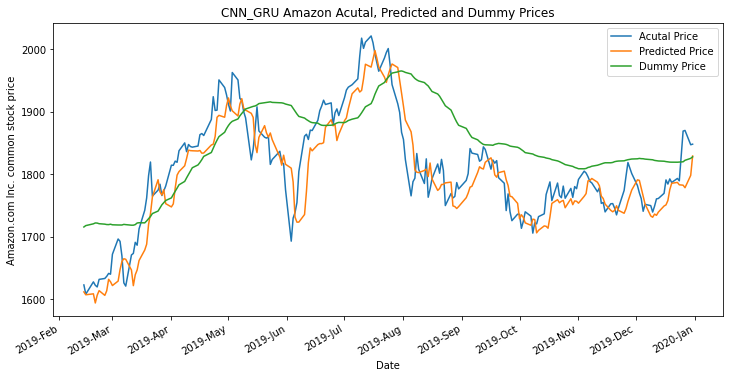

In [21]:
plotter = Security_Plotter(in_data, actual_price, predicted_price,
                            dummy_price, in_data.train_len, window_len, in_str, model_str)

plotter.single_plot()

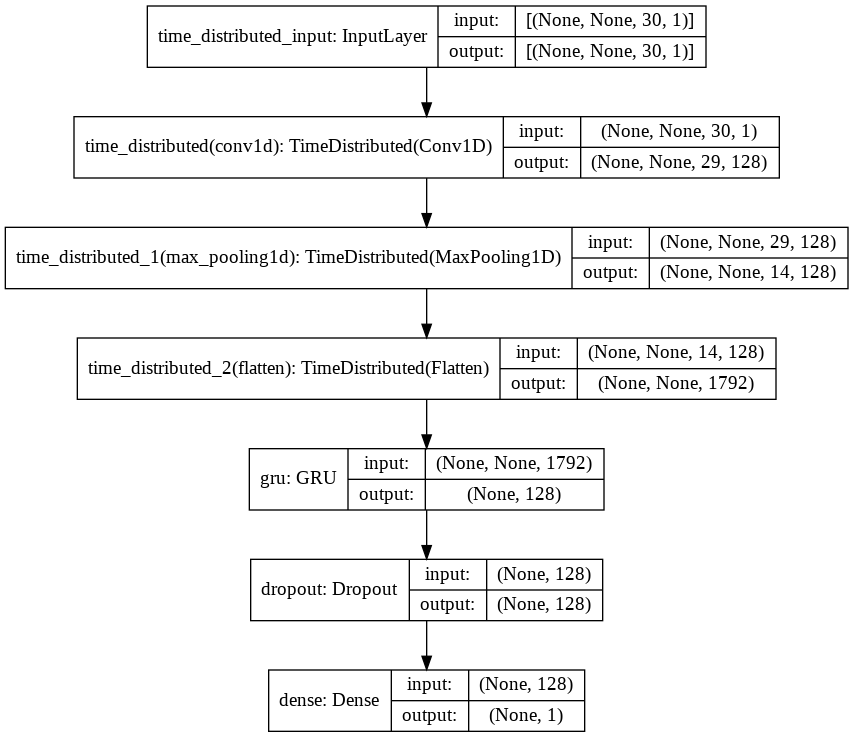

In [22]:
plot_model(model, show_shapes=True, expand_nested=True)

In [23]:
# calculating mean squared error
mse = mean_squared_error(y_true, y_pred)
d_mse = mean_squared_error(y_true, y_dummy)

# calculating root mean squared error
rmse = mean_squared_error(y_true, y_pred, squared=False)
d_rmse = mean_squared_error(y_true, y_dummy, squared=False)

# calculating mean absolute error
mae = mean_absolute_error(y_true, y_pred)
d_mae = mean_absolute_error(y_true, y_dummy)

print('MSE: ', mse)
print('RMSE: ', rmse)
print('MAE: ', mae)
print('Dummy MSE: ', d_mse)
print('Dummy RMSE: ', d_rmse)
print('Dummy MAE: ', d_mae)

MSE:  0.013698508206629538
RMSE:  0.11704062630825904
MAE:  0.09694781507719269
Dummy MSE:  0.03412892153519778
Dummy RMSE:  0.18474014597590255
Dummy MAE:  0.1546333417475681


In [24]:
# creating a string to save the model based on model name
save_path = '/content/gdrive/My Drive/models/'+model_str+'_'+in_str+'/'
# mounting google drive for easy storage of model
from google.colab import drive
# mounting the drive
drive.mount('/content/gdrive/')
# making the relevant directory to store the model
os.mkdir(save_path)
# saving the model
keras.models.save_model(model, save_path)
# saving the model graph
model_graph = plot_model(model, to_file=save_path+model_str+'_'+in_str+'_graph_.png', show_shapes=True, expand_nested=True)
# saving the matplotlib plot
plotter.fig.savefig(save_path+model_str+'_'+in_str+'_plot.png', bbox_inches='tight')
# saving the error metrics as a text file
error_file = open(save_path+model_str+'_'+in_str+'_metrics.txt', 'w+')
error_file.write('MSE: '+str(mse)+'\n'+'RMSE: '+str(rmse)+'\n'+'MAE: '+str(mae)+'\n'+
                 'Dummy MSE: '+str(d_mse)+'\n'+'Dummy RMSE: '+str(d_rmse)+'\n'+'Dummy MAE: '+str(d_mae))
error_file.close()

Mounted at /content/gdrive/


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/models/CNN_GRU_Amazon/assets


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/models/CNN_GRU_Amazon/assets
